In [1]:
# =============================================================================
# CELL 1: SETUP & IMPORTS
# =============================================================================
import os
import sys
import json
import warnings
from pathlib import Path
from datetime import datetime
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
sns.set_theme(style="whitegrid", palette="viridis")

# --- AUTO-DETECT ENVIRONMENT ---
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    import requests, zipfile
    DATA_URL = "https://bkuteam.site/data.zip"
    base_dir = Path("/content/ABC2026")
    base_dir.mkdir(parents=True, exist_ok=True)
    data_root = base_dir / "ABC2026 Sozolab Challenge"
    dataset_dir = data_root / "Dataset"
    
    if not (dataset_dir.exists() and any(dataset_dir.glob("*.csv"))):
        print("Downloading data.zip...")
        zip_path = base_dir / "data.zip"
        resp = requests.get(DATA_URL, stream=True)
        resp.raise_for_status()
        with open(zip_path, "wb") as f:
            for chunk in resp.iter_content(chunk_size=8192):
                if chunk: f.write(chunk)
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(base_dir)
    print(f"[COLAB] Data ready at: {dataset_dir}")
else:
    workspace = Path(r"E:\project\ABC2026")
    data_root = workspace / "ABC2026 Sozolab Challenge"
    dataset_dir = data_root / "Dataset"
    print(f"[LOCAL] Data at: {dataset_dir}")

DATA_ROOT = data_root
DATASET_DIR = dataset_dir

DATA_PATH = str(DATASET_DIR)
OUTPUT_PATH = str(DATA_ROOT)

# --- BEACON MAPPING (25 Beacons) ---
MAC_LIST = [
    'F7:7F:78:76:7E:F3', 'C6:CD:5E:3D:2F:BB', 'D6:F4:3A:79:74:63', 'C9:17:55:E2:3E:0E', 'CA:60:AB:EE:EC:7F',
    'D6:51:7F:AB:0E:29', 'CC:54:33:F6:A7:90', 'EB:20:56:87:04:5A', 'EE:E7:46:DC:19:6F', 'C8:5B:BF:37:07:A0',
    'D7:26:F6:A3:44:D2', 'DD:83:B0:27:FD:36', 'E5:CD:4A:36:87:06', 'DC:22:B8:17:4E:B5', 'EA:09:20:80:D6:44',
    'E6:99:D1:EC:C6:81', 'F6:DA:97:C7:D5:28', 'EA:66:A1:12:2C:F4', 'C9:EA:57:8B:0F:80', 'D6:7C:1D:2C:2A:0A',
    'DA:E1:70:5F:44:97', 'DD:10:10:F6:4F:27', 'E6:F3:93:A8:9E:22', 'E6:60:05:1F:88:F9', 'D4:33:FD:F4:C2:A8'
]
BEACON_IDS = [str(i) for i in range(1, 26)]
MAC_TO_BEACON = dict(zip(MAC_LIST, BEACON_IDS))

print(f"\n{'='*60}")
print(f"Environment: {'COLAB' if IS_COLAB else 'LOCAL'}")
print(f"Data Path: {DATA_PATH}")
print(f"Beacons: {len(BEACON_IDS)}")
print(f"{'='*60}")

[COLAB] Data ready at: /content/ABC2026/ABC2026 Sozolab Challenge/Dataset

Environment: COLAB
Data Path: /content/ABC2026/ABC2026 Sozolab Challenge/Dataset
Beacons: 25
[COLAB] Data ready at: /content/ABC2026/ABC2026 Sozolab Challenge/Dataset

Environment: COLAB
Data Path: /content/ABC2026/ABC2026 Sozolab Challenge/Dataset
Beacons: 25


In [2]:
# =============================================================================
# CELL 2: DATA LOADING & ALIGNMENT
# =============================================================================
print("Loading BLE and Label data...")

# 1. Find files
ble_folder = os.path.join(DATA_PATH, "BLE Data")
ble_files = [os.path.join(ble_folder, f) for f in os.listdir(ble_folder) 
             if f.endswith(".csv") and "user-ble-id_90" in f]

label_file = None
for f in os.listdir(DATA_PATH):
    if "label" in f.lower() and "train" in f.lower() and f.endswith(".csv"):
        label_file = os.path.join(DATA_PATH, f)

print(f"Found {len(ble_files)} BLE files")
print(f"Label file: {os.path.basename(label_file) if label_file else 'NOT FOUND'}")

# 2. Load BLE data
ble_dfs = []
for f in tqdm(ble_files, desc="Loading BLE"):
    try:
        df = pd.read_csv(f, header=None, names=['user_id', 'timestamp', 'scan_content', 'mac_address', 'RSSI', 'tx_power'])
        df = df[df['mac_address'].isin(MAC_LIST)].copy()
        if not df.empty:
            df['beacon_id'] = df['mac_address'].map(MAC_TO_BEACON)
            ble_dfs.append(df[['timestamp', 'beacon_id', 'RSSI']])
    except:
        pass

df_ble = pd.concat(ble_dfs, ignore_index=True)
df_ble['datetime'] = pd.to_datetime(df_ble['timestamp'], utc=True).dt.tz_convert('Asia/Tokyo')
df_ble = df_ble.sort_values('datetime').reset_index(drop=True)

# 3. Load Label data
df_lbl = pd.read_csv(label_file)
df_lbl = df_lbl[df_lbl['activity'] == 'Location'].copy()
for col in ['started_at', 'finished_at']:
    df_lbl[col] = pd.to_datetime(df_lbl[col])
    if df_lbl[col].dt.tz is None:
        df_lbl[col] = df_lbl[col].dt.tz_localize('Asia/Tokyo')
    else:
        df_lbl[col] = df_lbl[col].dt.tz_convert('Asia/Tokyo')

# 4. Align BLE with Labels
print("\nAligning BLE with Labels...")
labeled_data = []
for _, row in tqdm(df_lbl.iterrows(), total=len(df_lbl), desc="Aligning"):
    mask = (df_ble['datetime'] >= row['started_at']) & (df_ble['datetime'] <= row['finished_at'])
    subset = df_ble[mask].copy()
    if not subset.empty:
        subset['location'] = row['room']
        subset['label_user_id'] = row['user_id']
        labeled_data.append(subset)

df_raw = pd.concat(labeled_data, ignore_index=True)

# Summary
print(f"\n{'='*60}")
print("DATA LOADED SUCCESSFULLY")
print(f"{'='*60}")
print(f"Total samples: {len(df_raw):,}")
print(f"Time range: {df_raw['datetime'].min()} -> {df_raw['datetime'].max()}")
print(f"Locations: {df_raw['location'].nunique()}")
print(f"Beacons: {df_raw['beacon_id'].nunique()}")
print(f"Users: {sorted(df_raw['label_user_id'].unique())}")
print(f"{'='*60}")

Loading BLE and Label data...
Found 4107 BLE files
Label file: 5f_label_loc_train.csv


Loading BLE: 100%|██████████| 4107/4107 [00:15<00:00, 261.70it/s]




Aligning BLE with Labels...


Aligning: 100%|██████████| 1325/1325 [00:14<00:00, 92.18it/s] 



DATA LOADED SUCCESSFULLY
Total samples: 1,888,019
Time range: 2023-04-10 14:21:46.003000+09:00 -> 2023-04-13 12:50:50.675000+09:00
Locations: 44
Beacons: 25
Users: [np.int64(91), np.int64(97)]


EDA: CLASS IMBALANCE ANALYSIS

>>> KEY METRICS:
  Total samples: 1,888,019
  Num locations: 44
  Imbalance Ratio: 2,302x
  Gini Coefficient: 0.7832 (SEVERE)

>>> ALL LOCATIONS (sorted by sample count):
------------------------------------------------------------
   1. nurse station       :  538,553 (28.52%) ████████████████████████████
   2. Office Small        :  210,400 (11.14%) ███████████
   3. cafeteria           :  198,877 (10.53%) ██████████
   4. Office Large        :  193,737 (10.26%) ██████████
   5. kitchen             :  167,730 ( 8.88%) ████████
   6. Cafeteria D         :  157,583 ( 8.35%) ████████
   7. hallway             :  116,266 ( 6.16%) ██████
   8. 523                 :   34,405 ( 1.82%) █
   9. 513                 :   21,494 ( 1.14%) █
  10. 213                 :   21,478 ( 1.14%) █
  11. 208                 :   21,295 ( 1.13%) █
  12. cleaning            :   19,977 ( 1.06%) █
  13. Cafeteria A         :   18,335 ( 0.97%) 
  14. 201                 :   16,244 ( 0

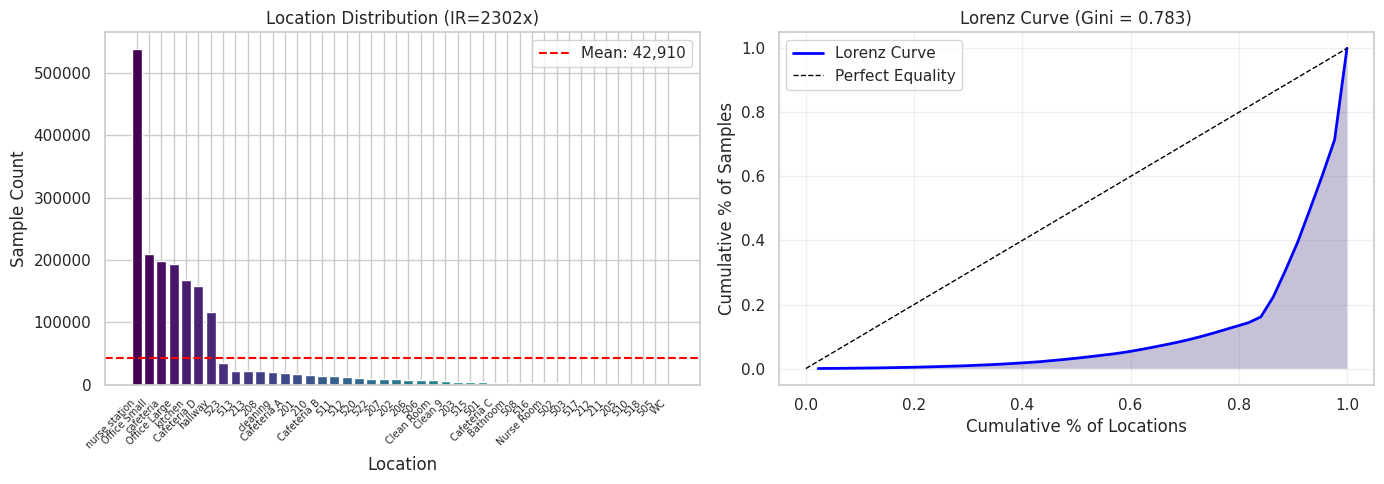

In [3]:
# =============================================================================
# CELL 3: EDA - CLASS IMBALANCE ANALYSIS
# =============================================================================
print("="*70)
print("EDA: CLASS IMBALANCE ANALYSIS")
print("="*70)

loc_counts = df_raw['location'].value_counts().sort_values(ascending=False)

# Metrics
imbalance_ratio = loc_counts.max() / loc_counts.min()

# Gini Coefficient
loc_sorted = loc_counts.sort_values()
cumsum = np.cumsum(loc_sorted.values)
lorenz_y = cumsum / cumsum[-1]
lorenz_x = np.arange(1, len(lorenz_y) + 1) / len(lorenz_y)
gini = 1 - 2 * np.trapz(lorenz_y, lorenz_x)

print(f"\n>>> KEY METRICS:")
print(f"  Total samples: {loc_counts.sum():,}")
print(f"  Num locations: {len(loc_counts)}")
print(f"  Imbalance Ratio: {imbalance_ratio:,.0f}x")
print(f"  Gini Coefficient: {gini:.4f} ({'SEVERE' if gini > 0.7 else 'HIGH' if gini > 0.5 else 'MODERATE'})")

print(f"\n>>> ALL LOCATIONS (sorted by sample count):")
print("-"*60)
for i, (loc, cnt) in enumerate(loc_counts.items(), 1):
    pct = cnt / loc_counts.sum() * 100
    bar = '█' * int(pct)
    print(f"  {i:2d}. {loc:20s}: {cnt:>8,} ({pct:5.2f}%) {bar}")
print("-"*60)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 0.8, len(loc_counts)))
ax1.bar(range(len(loc_counts)), loc_counts.values, color=colors)
ax1.axhline(loc_counts.mean(), color='red', linestyle='--', label=f'Mean: {loc_counts.mean():,.0f}')
ax1.set_xticks(range(len(loc_counts)))
ax1.set_xticklabels(loc_counts.index, rotation=45, ha='right', fontsize=7)
ax1.set_xlabel("Location")
ax1.set_ylabel("Sample Count")
ax1.set_title(f"Location Distribution (IR={imbalance_ratio:.0f}x)")
ax1.legend()

# Lorenz curve
ax2 = axes[1]
ax2.plot(lorenz_x, lorenz_y, 'b-', linewidth=2, label='Lorenz Curve')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect Equality')
ax2.fill_between(lorenz_x, lorenz_y, alpha=0.3)
ax2.set_xlabel("Cumulative % of Locations")
ax2.set_ylabel("Cumulative % of Samples")
ax2.set_title(f"Lorenz Curve (Gini = {gini:.3f})")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

EDA: BEACON COVERAGE & SIGNAL QUALITY

>>> BEACON COVERAGE:
  Mean coverage: 4.00%
  Zero pairs: 413 / 1100 (37.55%)

>>> SIGNAL QUALITY:
  Mean RSSI: -93.00 dBm
  Std RSSI: 4.23 dBm
  strong (> -70): 0 (0.00%)
  moderate (-70 to -85): 86,206 (4.57%)
  weak (-85 to -95): 1,038,905 (55.03%)
  very_weak (<= -95): 762,908 (40.41%)

>>> BEACON DETECTION (sorted by count):
--------------------------------------------------
  Beacon  4:  400,432 (21.21%) ██████████████████████████████████████████
  Beacon  9:  382,287 (20.25%) ████████████████████████████████████████
  Beacon 14:  266,152 (14.10%) ████████████████████████████
  Beacon  7:  153,467 ( 8.13%) ████████████████
  Beacon 19:  131,798 ( 6.98%) █████████████
  Beacon 18:   78,006 ( 4.13%) ████████
  Beacon  8:   64,883 ( 3.44%) ██████
  Beacon 20:   61,138 ( 3.24%) ██████
  Beacon  6:   60,532 ( 3.21%) ██████
  Beacon 10:   37,541 ( 1.99%) ███
  Beacon 23:   37,483 ( 1.99%) ███
  Beacon 11:   37,466 ( 1.98%) ███
  Beacon 21:   35,01

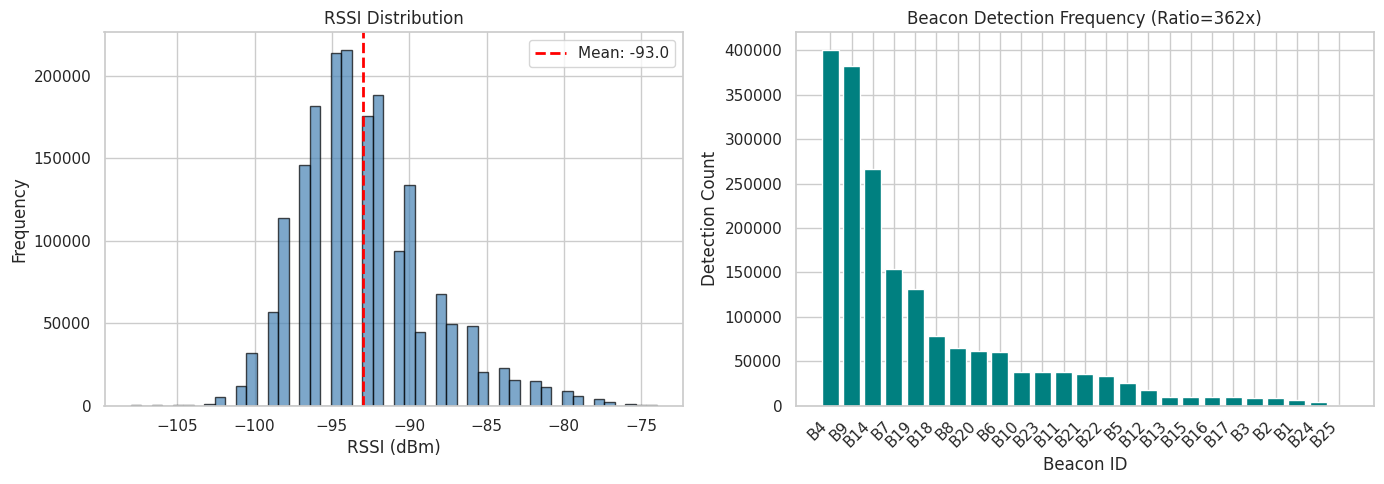

In [4]:
# =============================================================================
# CELL 4: EDA - BEACON COVERAGE & SIGNAL QUALITY
# =============================================================================
print("="*70)
print("EDA: BEACON COVERAGE & SIGNAL QUALITY")
print("="*70)

# Beacon detection frequency
beacon_counts = df_raw['beacon_id'].value_counts().sort_values(ascending=False)

# Coverage matrix
sparsity_data = []
for loc in df_raw['location'].unique():
    df_loc = df_raw[df_raw['location'] == loc]
    total = len(df_loc)
    for b in BEACON_IDS:
        cnt = (df_loc['beacon_id'] == b).sum()
        coverage = (cnt / total * 100) if total > 0 else 0
        sparsity_data.append({'location': loc, 'beacon_id': b, 'coverage_pct': coverage})

df_sparsity = pd.DataFrame(sparsity_data)
coverage_pivot = df_sparsity.pivot(index='location', columns='beacon_id', values='coverage_pct')
coverage_pivot = coverage_pivot[sorted(coverage_pivot.columns, key=lambda x: int(x))]

# Signal quality
rssi_data = df_raw['RSSI']
rssi_ranges = {
    "strong (> -70)": (rssi_data > -70).sum(),
    "moderate (-70 to -85)": ((rssi_data <= -70) & (rssi_data > -85)).sum(),
    "weak (-85 to -95)": ((rssi_data <= -85) & (rssi_data > -95)).sum(),
    "very_weak (<= -95)": (rssi_data <= -95).sum(),
}

# Print summary
print(f"\n>>> BEACON COVERAGE:")
print(f"  Mean coverage: {coverage_pivot.mean().mean():.2f}%")
print(f"  Zero pairs: {(coverage_pivot == 0).sum().sum()} / {coverage_pivot.size} ({(coverage_pivot == 0).sum().sum() / coverage_pivot.size * 100:.2f}%)")

print(f"\n>>> SIGNAL QUALITY:")
print(f"  Mean RSSI: {rssi_data.mean():.2f} dBm")
print(f"  Std RSSI: {rssi_data.std():.2f} dBm")
for rng, cnt in rssi_ranges.items():
    print(f"  {rng}: {cnt:,} ({cnt/len(rssi_data)*100:.2f}%)")

print(f"\n>>> BEACON DETECTION (sorted by count):")
print("-"*50)
for bid, cnt in beacon_counts.items():
    pct = cnt / beacon_counts.sum() * 100
    bar = '█' * int(pct * 2)
    print(f"  Beacon {bid:>2s}: {cnt:>8,} ({pct:5.2f}%) {bar}")
print("-"*50)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RSSI histogram
ax1 = axes[0]
ax1.hist(rssi_data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(rssi_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rssi_data.mean():.1f}')
ax1.set_xlabel("RSSI (dBm)")
ax1.set_ylabel("Frequency")
ax1.set_title("RSSI Distribution")
ax1.legend()

# Beacon detection
ax2 = axes[1]
ax2.bar(range(len(beacon_counts)), beacon_counts.values, color='teal')
ax2.set_xticks(range(len(beacon_counts)))
ax2.set_xticklabels([f"B{i}" for i in beacon_counts.index], rotation=45, ha='right')
ax2.set_xlabel("Beacon ID")
ax2.set_ylabel("Detection Count")
ax2.set_title(f"Beacon Detection Frequency (Ratio={beacon_counts.max()/beacon_counts.min():.0f}x)")

plt.tight_layout()
plt.show()

In [5]:
# =============================================================================
# CELL 5: FEATURE ENGINEERING - SLIDING WINDOW
# =============================================================================
print("="*70)
print("FEATURE ENGINEERING: SLIDING WINDOW (5s)")
print("="*70)

WINDOW_SIZE = '5s'
DEFAULT_RSSI = -110

df_fe = df_raw[['datetime', 'beacon_id', 'RSSI', 'location']].copy()
df_fe = df_fe.set_index('datetime')

windowed_list = []
for loc in tqdm(sorted(df_fe['location'].unique()), desc="Processing Locations"):
    df_loc = df_fe[df_fe['location'] == loc][['beacon_id', 'RSSI']].copy()
    
    # Pivot and resample
    df_pivot = df_loc.pivot_table(index=df_loc.index, columns='beacon_id', values='RSSI', aggfunc='mean')
    df_resampled = df_pivot.resample(WINDOW_SIZE).mean()
    df_resampled = df_resampled.dropna(how='all')
    
    if len(df_resampled) == 0:
        continue
    
    # Ensure all beacons
    for b in BEACON_IDS:
        if b not in df_resampled.columns:
            df_resampled[b] = np.nan
    
    df_resampled = df_resampled[sorted(df_resampled.columns, key=lambda x: int(x))]
    df_resampled = df_resampled.fillna(DEFAULT_RSSI)
    df_resampled['location'] = loc
    df_resampled = df_resampled.reset_index(drop=True)
    windowed_list.append(df_resampled)

df_windowed = pd.concat(windowed_list, ignore_index=True)
feature_cols = [str(i) for i in range(1, 26)]
df_windowed = df_windowed[feature_cols + ['location']]

print(f"\n>>> WINDOWING RESULT:")
print(f"  Original samples: {len(df_raw):,}")
print(f"  Windowed samples: {len(df_windowed):,}")
print(f"  Compression ratio: {len(df_raw) / len(df_windowed):.2f}x")
print(f"  Features: {len(feature_cols)}")
print(f"  Locations: {df_windowed['location'].nunique()}")

print(f"\n>>> SAMPLES PER LOCATION:")
loc_dist = df_windowed['location'].value_counts()
for loc, cnt in loc_dist.head(10).items():
    print(f"  {loc}: {cnt}")
print(f"  ... ({len(loc_dist)} total locations)")

df_windowed.head()

FEATURE ENGINEERING: SLIDING WINDOW (5s)


Processing Locations: 100%|██████████| 44/44 [00:07<00:00,  5.71it/s]


>>> WINDOWING RESULT:
  Original samples: 1,888,019
  Windowed samples: 11,543
  Compression ratio: 163.56x
  Features: 25
  Locations: 44

>>> SAMPLES PER LOCATION:
  nurse station: 2125
  Office Small: 1426
  kitchen: 1398
  Cafeteria D: 1304
  cafeteria: 1196
  hallway: 766
  Office Large: 655
  cleaning: 245
  213: 231
  Cafeteria A: 221
  ... (44 total locations)


beacon_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,location
0,-93.0,-85.000000,-90.0,-110.0,-110.00000,-110.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-86.0,-110.000000,-90.0,-89.125,-110.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,201
1,-110.0,-87.444444,-88.4,-96.0,-91.41791,-92.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-96.0,-110.000000,-96.0,-89.250,-90.941176,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,201
2,-110.0,-100.000000,-93.0,-110.0,-89.94186,-89.666667,-110.0,-110.0,-94.0,-110.0,-110.0,-110.0,-110.0,-110.000000,-110.0,-110.000,-98.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,201
3,-110.0,-110.000000,-110.0,-110.0,-95.50000,-98.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-95.666667,-110.0,-110.000,-110.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,201
4,-110.0,-110.000000,-110.0,-110.0,-96.00000,-95.222222,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-94.000000,-110.0,-110.000,-110.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,201


In [6]:
# =============================================================================
# CELL 6: EXTENDED FEATURES (Binary + Rank + DRSS)
# =============================================================================
print("="*70)
print("EXTENDED FEATURES (NO Matrix Completion - Avoid Data Leakage)")
print("="*70)

def create_binary_features(df, threshold=-105):
    """Binary fingerprint: 1 if signal > threshold"""
    beacon_cols = [str(i) for i in range(1, 26)]
    binary_df = (df[beacon_cols] > threshold).astype(int)
    binary_df.columns = [f'bin_{c}' for c in beacon_cols]
    coverage = binary_df.sum(axis=1)
    coverage.name = 'coverage_count'
    return binary_df, coverage

def create_rank_features(df):
    """Rank features: 1 = strongest signal"""
    beacon_cols = [str(i) for i in range(1, 26)]
    rank_df = df[beacon_cols].rank(axis=1, method='dense', ascending=False)
    rank_df.columns = [f'rank_{c}' for c in beacon_cols]
    return rank_df

def create_drss_features(df, top_pairs=16):
    """Differential RSSI: differences between beacon pairs"""
    beacon_cols = [str(i) for i in range(1, 26)]
    pairs = list(combinations(beacon_cols, 2))
    drss_data = {f'drss_{b1}_{b2}': df[b1] - df[b2] for b1, b2 in pairs}
    drss_df = pd.DataFrame(drss_data)
    # Select top pairs by variance
    variances = drss_df.var().sort_values(ascending=False)
    top_cols = variances.head(top_pairs).index.tolist()
    return drss_df[top_cols]

# Create all features
X_binary, coverage = create_binary_features(df_windowed)
X_rank = create_rank_features(df_windowed)
X_drss = create_drss_features(df_windowed, top_pairs=16)

print(f"\n>>> FEATURE SUMMARY:")
print(f"  Mean RSSI: {len(feature_cols)} features")
print(f"  Binary: {len(X_binary.columns)} features (threshold=-105 dBm)")
print(f"  Rank: {len(X_rank.columns)} features")
print(f"  DRSS: {len(X_drss.columns)} features (top by variance)")
print(f"  Coverage: 1 feature")
print(f"  TOTAL: {len(feature_cols) + len(X_binary.columns) + len(X_rank.columns) + len(X_drss.columns) + 1} features")

# Combine all features
X_mean = df_windowed[feature_cols].copy()
X_mean.columns = [f'mean_{c}' for c in feature_cols]

X_full = pd.concat([X_mean, X_binary, coverage.to_frame(), X_rank, X_drss], axis=1)
y_labels = df_windowed['location'].values

print(f"\n>>> FINAL FEATURE MATRIX: {X_full.shape}")
print(f"\n>>> COVERAGE DISTRIBUTION:")
cov_dist = coverage.value_counts().sort_index()
for cov, cnt in cov_dist.items():
    print(f"  {cov:2d} beacons: {cnt:>5} ({cnt/len(coverage)*100:5.2f}%)")

X_full.head()

EXTENDED FEATURES (NO Matrix Completion - Avoid Data Leakage)

>>> FEATURE SUMMARY:
  Mean RSSI: 25 features
  Binary: 25 features (threshold=-105 dBm)
  Rank: 25 features
  DRSS: 16 features (top by variance)
  Coverage: 1 feature
  TOTAL: 92 features

>>> FINAL FEATURE MATRIX: (11543, 92)

>>> COVERAGE DISTRIBUTION:
   0 beacons:     1 ( 0.01%)
   1 beacons:  1890 (16.37%)
   2 beacons:  3194 (27.67%)
   3 beacons:  2261 (19.59%)
   4 beacons:  1441 (12.48%)
   5 beacons:   911 ( 7.89%)
   6 beacons:   634 ( 5.49%)
   7 beacons:   464 ( 4.02%)
   8 beacons:   379 ( 3.28%)
   9 beacons:   198 ( 1.72%)
  10 beacons:   120 ( 1.04%)
  11 beacons:    47 ( 0.41%)
  12 beacons:     2 ( 0.02%)
  13 beacons:     1 ( 0.01%)

>>> FEATURE SUMMARY:
  Mean RSSI: 25 features
  Binary: 25 features (threshold=-105 dBm)
  Rank: 25 features
  DRSS: 16 features (top by variance)
  Coverage: 1 feature
  TOTAL: 92 features

>>> FINAL FEATURE MATRIX: (11543, 92)

>>> COVERAGE DISTRIBUTION:
   0 beacons:   

,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,mean_10,mean_11,mean_12,mean_13,mean_14,mean_15,mean_16,mean_17,mean_18,mean_19,mean_20,mean_21,mean_22,mean_23,mean_24,mean_25,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10,bin_11,bin_12,bin_13,bin_14,bin_15,bin_16,bin_17,bin_18,bin_19,bin_20,bin_21,bin_22,bin_23,bin_24,bin_25,coverage_count,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10,rank_11,rank_12,rank_13,rank_14,rank_15,rank_16,rank_17,rank_18,rank_19,rank_20,rank_21,rank_22,rank_23,rank_24,rank_25,drss_9_14,drss_7_14,drss_14_19,drss_14_18,drss_8_14,drss_14_20,drss_4_20,drss_4_8,drss_4_18,drss_4_9,drss_10_14,drss_4_10,drss_6_9,drss_4_7,drss_14_21,drss_11_14
0,-93.0,-85.000000,-90.0,-110.0,-110.00000,-110.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-86.0,-110.000000,-90.0,-89.125,-110.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,6,5.0,1.0,4.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,2.0,6.0,4.0,3.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,-110.0,-87.444444,-88.4,-96.0,-91.41791,-92.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-96.0,-110.000000,-96.0,-89.250,-90.941176,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,0,1,1,1,1,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,9,8.0,1.0,2.0,7.0,5.0,6.0,8.0,8.0,8.0,8.0,8.0,8.0,7.0,8.0,7.0,3.0,4.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.0,14.0,14.0,14.0,0.000000,14.0,18.000000,14.0,0.000000,0.000000
2,-110.0,-100.000000,-93.0,-110.0,-89.94186,-89.666667,-110.0,-110.0,-94.0,-110.0,-110.0,-110.0,-110.0,-110.000000,-110.0,-110.000,-98.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6,7.0,6.0,3.0,7.0,2.0,1.0,7.0,7.0,4.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,5.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-16.0,0.000000,0.0,4.333333,0.0,0.000000,0.000000
3,-110.0,-110.000000,-110.0,-110.0,-95.50000,-98.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-95.666667,-110.0,-110.000,-110.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,4.0,4.0,4.0,4.0,1.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,-14.333333,-14.333333,14.333333,14.333333,-14.333333,14.333333,0.0,0.0,0.0,0.0,-14.333333,0.0,12.000000,0.0,14.333333,-14.333333
4,-110.0,-110.000000,-110.0,-110.0,-96.00000,-95.222222,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-94.000000,-110.0,-110.000,-110.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,4.0,4.0,4.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,-16.000000,-16.000000,16.000000,16.000000,-16.000000,16.000000,0.0,0.0,0.0,0.0,-16.000000,0.0,14.777778,0.0,16.000000,-16.000000


FEATURE QUALITY: PCA ANALYSIS

>>> PCA RESULTS:
  Total components: 92
  PC1 variance: 34.23%
  PC2 variance: 12.99%
  PC1+PC2: 47.22%
  Components for 80%: 9
  Components for 90%: 16

>>> EXPLAINED VARIANCE (first 15 components):
  PC 1:  34.23% (cumulative:  34.23%) █████████████████
  PC 2:  12.99% (cumulative:  47.22%) ██████
  PC 3:  10.78% (cumulative:  58.01%) █████
  PC 4:   8.67% (cumulative:  66.67%) ████
  PC 5:   4.48% (cumulative:  71.16%) ██
  PC 6:   3.28% (cumulative:  74.44%) █
  PC 7:   2.91% (cumulative:  77.35%) █
  PC 8:   2.24% (cumulative:  79.59%) █
  PC 9:   1.82% (cumulative:  81.41%) 
  PC10:   1.54% (cumulative:  82.95%) 
  PC11:   1.40% (cumulative:  84.36%) 
  PC12:   1.30% (cumulative:  85.65%) 
  PC13:   1.28% (cumulative:  86.93%) 
  PC14:   1.15% (cumulative:  88.09%) 
  PC15:   1.12% (cumulative:  89.21%) 

>>> PCA RESULTS:
  Total components: 92
  PC1 variance: 34.23%
  PC2 variance: 12.99%
  PC1+PC2: 47.22%
  Components for 80%: 9
  Components for 9

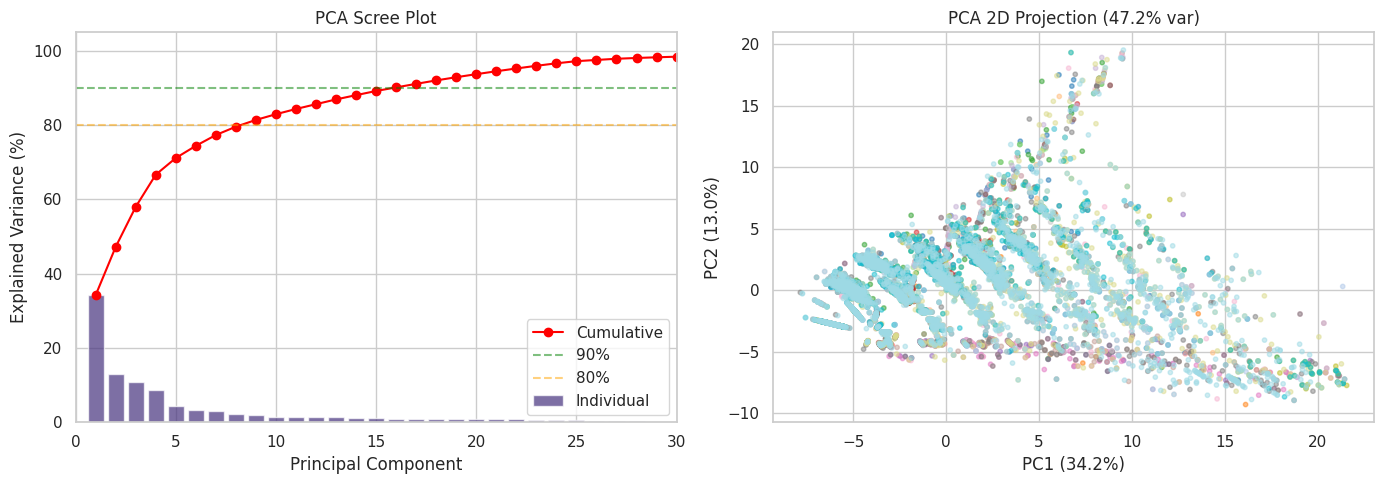

In [7]:
# =============================================================================
# CELL 7: FEATURE QUALITY - PCA ANALYSIS
# =============================================================================
print("="*70)
print("FEATURE QUALITY: PCA ANALYSIS")
print("="*70)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# PCA
pca = PCA()
pca.fit(X_scaled)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
n_components_90 = np.argmax(cumulative_var >= 0.90) + 1
n_components_80 = np.argmax(cumulative_var >= 0.80) + 1

print(f"\n>>> PCA RESULTS:")
print(f"  Total components: {len(explained_var)}")
print(f"  PC1 variance: {explained_var[0]*100:.2f}%")
print(f"  PC2 variance: {explained_var[1]*100:.2f}%")
print(f"  PC1+PC2: {(explained_var[0]+explained_var[1])*100:.2f}%")
print(f"  Components for 80%: {n_components_80}")
print(f"  Components for 90%: {n_components_90}")

print(f"\n>>> EXPLAINED VARIANCE (first 15 components):")
for i, (var, cum) in enumerate(zip(explained_var[:15], cumulative_var[:15]), 1):
    bar = '█' * int(var * 100 / 2)
    print(f"  PC{i:2d}: {var*100:6.2f}% (cumulative: {cum*100:6.2f}%) {bar}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.bar(range(1, len(explained_var)+1), explained_var * 100, alpha=0.7, label='Individual')
ax1.plot(range(1, len(cumulative_var)+1), cumulative_var * 100, 'ro-', label='Cumulative')
ax1.axhline(90, color='green', linestyle='--', alpha=0.5, label='90%')
ax1.axhline(80, color='orange', linestyle='--', alpha=0.5, label='80%')
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance (%)")
ax1.set_title("PCA Scree Plot")
ax1.legend()
ax1.set_xlim(0, 30)

# 2D projection
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)

ax2 = axes[1]
scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.factorize(y_labels)[0], 
                       cmap='tab20', s=10, alpha=0.5)
ax2.set_xlabel(f"PC1 ({explained_var[0]*100:.1f}%)")
ax2.set_ylabel(f"PC2 ({explained_var[1]*100:.1f}%)")
ax2.set_title(f"PCA 2D Projection ({(explained_var[0]+explained_var[1])*100:.1f}% var)")

plt.tight_layout()
plt.show()

In [8]:
# =============================================================================
# CELL 8: DATA PREPARATION FOR MODELING
# =============================================================================
print("="*70)
print("DATA PREPARATION FOR MODELING")
print("="*70)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y_labels)
class_names = le.classes_

print(f"\n>>> DATASET:")
print(f"  X shape: {X_full.shape}")
print(f"  y shape: {y.shape}")
print(f"  Classes: {len(class_names)}")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

print(f"\n>>> CLASS WEIGHTS (balanced):")
sorted_weights = sorted(class_weight_dict.items(), key=lambda x: x[1], reverse=True)
for cls, w in sorted_weights[:5]:
    print(f"  Class {cls} ({class_names[cls][:15]}...): {w:.4f}")
print(f"  ... ({len(class_weight_dict)} total classes)")

# Create Stratified K-Fold
N_FOLDS = 5
RANDOM_STATE = 42
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

fold_indices = []
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_full, y)):
    fold_indices.append({'fold': fold_idx, 'train_idx': train_idx, 'val_idx': val_idx})

print(f"\n>>> STRATIFIED {N_FOLDS}-FOLD CV:")
print("-"*50)
for fold in fold_indices:
    print(f"  Fold {fold['fold']}: Train={len(fold['train_idx']):,}, Val={len(fold['val_idx']):,}")
print("-"*50)

# Define feature sets for experiments
FEATURE_SETS = {
    'mean_only': [c for c in X_full.columns if c.startswith('mean_')],
    'mean+binary': [c for c in X_full.columns if c.startswith('mean_') or c.startswith('bin_') or c == 'coverage_count'],
    'full': list(X_full.columns),
}

print(f"\n>>> FEATURE SETS FOR EXPERIMENTS:")
for name, cols in FEATURE_SETS.items():
    print(f"  {name}: {len(cols)} features")

DATA PREPARATION FOR MODELING

>>> DATASET:
  X shape: (11543, 92)
  y shape: (11543,)
  Classes: 44

>>> CLASS WEIGHTS (balanced):
  Class 38 (WC...): 87.4470
  Class 22 (516...): 43.7235
  Class 9 (212...): 32.7926
  Class 14 (505...): 32.7926
  Class 23 (517...): 32.7926
  ... (44 total classes)

>>> STRATIFIED 5-FOLD CV:
--------------------------------------------------
  Fold 0: Train=9,234, Val=2,309
  Fold 1: Train=9,234, Val=2,309
  Fold 2: Train=9,234, Val=2,309
  Fold 3: Train=9,235, Val=2,308
  Fold 4: Train=9,235, Val=2,308
--------------------------------------------------

>>> FEATURE SETS FOR EXPERIMENTS:
  mean_only: 25 features
  mean+binary: 51 features
  full: 92 features


In [9]:
# =============================================================================
# CELL 9: XGBOOST BASELINE (5-Fold CV)
# =============================================================================
print("="*70)
print("XGBOOST BASELINE (5-Fold CV)")
print("="*70)

# Check if XGBoost is available
try:
    import xgboost as xgb
    print(f"XGBoost version: {xgb.__version__}")
except ImportError:
    print("Installing XGBoost...")
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'xgboost', '-q'])
    import xgboost as xgb

def train_xgboost_cv(X_df, y, feature_cols, fold_indices, class_weights=None, n_estimators=200):
    """
    Train XGBoost with Stratified K-Fold CV.
    Returns fold results and predictions.
    """
    X = X_df[feature_cols].values
    results = []
    
    for fold_info in fold_indices:
        fold = fold_info['fold']
        train_idx = fold_info['train_idx']
        val_idx = fold_info['val_idx']
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Sample weights
        if class_weights:
            sample_weights = np.array([class_weights.get(yi, 1.0) for yi in y_train])
        else:
            sample_weights = None
        
        # Train
        model = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='multi:softmax',
            num_class=len(np.unique(y)),
            random_state=42,
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_jobs=-1,
            verbosity=0
        )
        
        model.fit(X_train, y_train, sample_weight=sample_weights)
        
        # Predict
        y_pred = model.predict(X_val)
        
        # Metrics
        f1_macro = f1_score(y_val, y_pred, average='macro')
        f1_weighted = f1_score(y_val, y_pred, average='weighted')
        
        results.append({
            'fold': fold,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'model': model
        })
        
        print(f"  Fold {fold}: Macro F1 = {f1_macro:.4f}, Weighted F1 = {f1_weighted:.4f}")
    
    return results

# Run experiments
all_results = {}

for feat_name, feat_cols in FEATURE_SETS.items():
    print(f"\n>>> Training with {feat_name.upper()} ({len(feat_cols)} features)...")
    results = train_xgboost_cv(X_full, y, feat_cols, fold_indices, class_weight_dict)
    all_results[feat_name] = results
    
    mean_f1 = np.mean([r['f1_macro'] for r in results])
    std_f1 = np.std([r['f1_macro'] for r in results])
    print(f"  >>> Mean Macro F1: {mean_f1:.4f} ± {std_f1:.4f}")

XGBOOST BASELINE (5-Fold CV)
XGBoost version: 3.1.2

>>> Training with MEAN_ONLY (25 features)...
XGBoost version: 3.1.2

>>> Training with MEAN_ONLY (25 features)...
  Fold 0: Macro F1 = 0.1385, Weighted F1 = 0.1989
  Fold 0: Macro F1 = 0.1385, Weighted F1 = 0.1989
  Fold 1: Macro F1 = 0.1478, Weighted F1 = 0.2034
  Fold 1: Macro F1 = 0.1478, Weighted F1 = 0.2034
  Fold 2: Macro F1 = 0.1405, Weighted F1 = 0.1960
  Fold 2: Macro F1 = 0.1405, Weighted F1 = 0.1960
  Fold 3: Macro F1 = 0.1479, Weighted F1 = 0.1993
  Fold 3: Macro F1 = 0.1479, Weighted F1 = 0.1993
  Fold 4: Macro F1 = 0.1338, Weighted F1 = 0.1885
  >>> Mean Macro F1: 0.1417 ± 0.0055

>>> Training with MEAN+BINARY (51 features)...
  Fold 4: Macro F1 = 0.1338, Weighted F1 = 0.1885
  >>> Mean Macro F1: 0.1417 ± 0.0055

>>> Training with MEAN+BINARY (51 features)...
  Fold 0: Macro F1 = 0.1430, Weighted F1 = 0.2002
  Fold 0: Macro F1 = 0.1430, Weighted F1 = 0.2002
  Fold 1: Macro F1 = 0.1436, Weighted F1 = 0.2045
  Fold 1: Mac

RESULTS SUMMARY

>>> EXPERIMENT RESULTS:
--------------------------------------------------------------------------------
Feature Set     |   Num Feat |    Mean F1 |     Std F1 |                Range
--------------------------------------------------------------------------------
mean_only       |         25 |     0.1417 |     0.0055 | [0.1338, 0.1479]
mean+binary     |         51 |     0.1416 |     0.0036 | [0.1367, 0.1463]
full            |         92 |     0.1326 |     0.0041 | [0.1251, 0.1367]
--------------------------------------------------------------------------------

>>> BEST MODEL: MEAN_ONLY with Mean Macro F1 = 0.1417


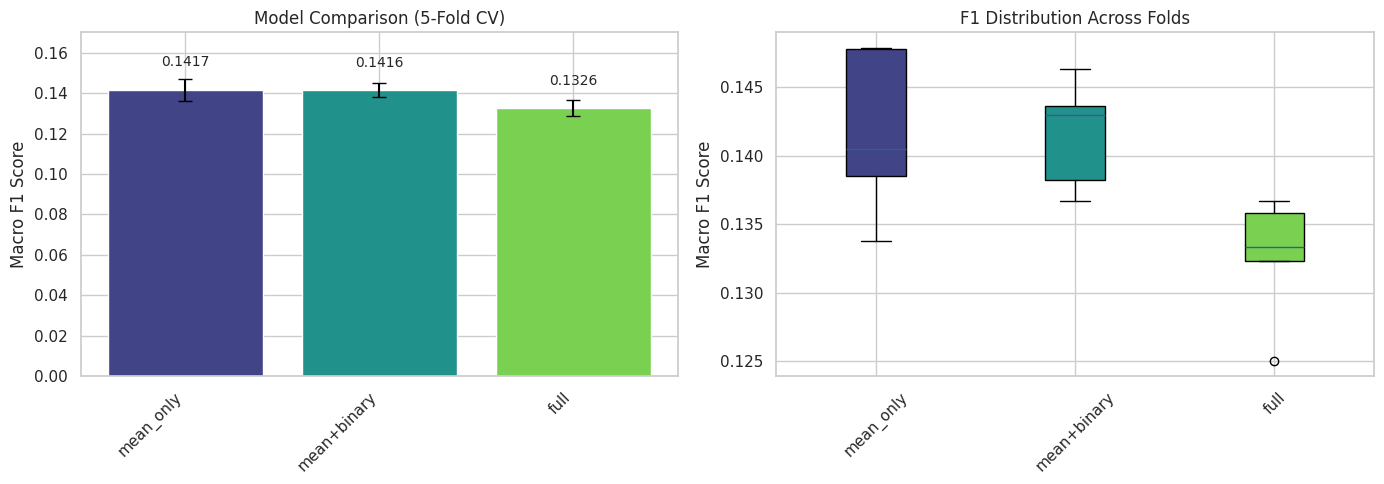

In [10]:
# =============================================================================
# CELL 10: RESULTS SUMMARY & VISUALIZATION
# =============================================================================
print("="*70)
print("RESULTS SUMMARY")
print("="*70)

# Compile results
summary_rows = []
for feat_name, results in all_results.items():
    f1_scores = [r['f1_macro'] for r in results]
    summary_rows.append({
        'Feature Set': feat_name,
        'Num Features': len(FEATURE_SETS[feat_name]),
        'Mean F1': np.mean(f1_scores),
        'Std F1': np.std(f1_scores),
        'Min F1': np.min(f1_scores),
        'Max F1': np.max(f1_scores),
    })

df_summary = pd.DataFrame(summary_rows).sort_values('Mean F1', ascending=False)

print("\n>>> EXPERIMENT RESULTS:")
print("-"*80)
print(f"{'Feature Set':<15} | {'Num Feat':>10} | {'Mean F1':>10} | {'Std F1':>10} | {'Range':>20}")
print("-"*80)
for _, row in df_summary.iterrows():
    print(f"{row['Feature Set']:<15} | {row['Num Features']:>10} | {row['Mean F1']:>10.4f} | {row['Std F1']:>10.4f} | [{row['Min F1']:.4f}, {row['Max F1']:.4f}]")
print("-"*80)

# Best model
best_feat = df_summary.iloc[0]['Feature Set']
best_f1 = df_summary.iloc[0]['Mean F1']
print(f"\n>>> BEST MODEL: {best_feat.upper()} with Mean Macro F1 = {best_f1:.4f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(df_summary)))
bars = ax1.bar(range(len(df_summary)), df_summary['Mean F1'].values, 
               yerr=df_summary['Std F1'].values, capsize=5, color=colors)
ax1.set_xticks(range(len(df_summary)))
ax1.set_xticklabels(df_summary['Feature Set'], rotation=45, ha='right')
ax1.set_ylabel('Macro F1 Score')
ax1.set_title('Model Comparison (5-Fold CV)')
ax1.set_ylim(0, max(df_summary['Mean F1']) * 1.2)

# Add values on bars
for i, (bar, val) in enumerate(zip(bars, df_summary['Mean F1'])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Boxplot of fold results
ax2 = axes[1]
fold_data = []
labels = []
for feat_name in df_summary['Feature Set']:
    fold_data.append([r['f1_macro'] for r in all_results[feat_name]])
    labels.append(feat_name)

bp = ax2.boxplot(fold_data, labels=labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax2.set_ylabel('Macro F1 Score')
ax2.set_title('F1 Distribution Across Folds')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

BEST MODEL ANALYSIS

>>> TOP 20 FEATURES:
--------------------------------------------------
   1. mean_17             : 0.0875 ████████
   2. mean_2              : 0.0726 ███████
   3. mean_16             : 0.0666 ██████
   4. mean_13             : 0.0584 █████
   5. mean_22             : 0.0551 █████
   6. mean_1              : 0.0504 █████
   7. mean_3              : 0.0395 ███
   8. mean_21             : 0.0390 ███
   9. mean_8              : 0.0383 ███
  10. mean_23             : 0.0373 ███
  11. mean_5              : 0.0358 ███
  12. mean_12             : 0.0356 ███
  13. mean_11             : 0.0353 ███
  14. mean_25             : 0.0349 ███
  15. mean_20             : 0.0348 ███
  16. mean_18             : 0.0334 ███
  17. mean_15             : 0.0321 ███
  18. mean_14             : 0.0302 ███
  19. mean_10             : 0.0297 ██
  20. mean_4              : 0.0288 ██
--------------------------------------------------

>>> RETRAINING ON FULL DATA...
  Final model trained!
  Fin

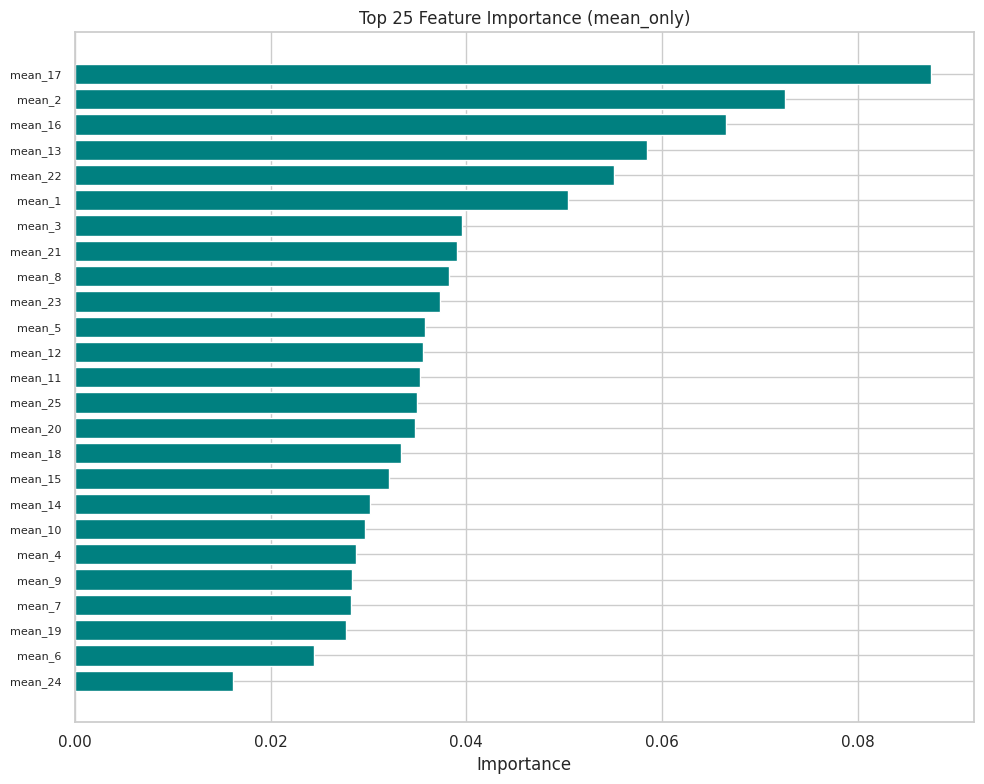

In [11]:
# =============================================================================
# CELL 11: BEST MODEL ANALYSIS
# =============================================================================
print("="*70)
print("BEST MODEL ANALYSIS")
print("="*70)

# Get best model from last fold
best_results = all_results[best_feat]
best_model = best_results[-1]['model']  # Last fold

# Feature importance
feat_importance = best_model.feature_importances_
feat_names = FEATURE_SETS[best_feat]
importance_df = pd.DataFrame({
    'feature': feat_names,
    'importance': feat_importance
}).sort_values('importance', ascending=False)

print(f"\n>>> TOP 20 FEATURES:")
print("-"*50)
for i, (_, row) in enumerate(importance_df.head(20).iterrows(), 1):
    bar = '█' * int(row['importance'] * 100)
    print(f"  {i:2d}. {row['feature']:<20}: {row['importance']:.4f} {bar}")
print("-"*50)

# Retrain on full data for final evaluation
print(f"\n>>> RETRAINING ON FULL DATA...")
X_final = X_full[feat_names].values
final_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    verbosity=0
)

sample_weights = np.array([class_weight_dict.get(yi, 1.0) for yi in y])
final_model.fit(X_final, y, sample_weight=sample_weights)
print("  Final model trained!")

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_n = min(25, len(importance_df))
top_feats = importance_df.head(top_n)
ax.barh(range(top_n), top_feats['importance'].values[::-1], color='teal')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_feats['feature'].values[::-1], fontsize=8)
ax.set_xlabel('Importance')
ax.set_title(f'Top {top_n} Feature Importance ({best_feat})')
plt.tight_layout()
plt.show()

In [12]:
# =============================================================================
# CELL 12: FINAL SUMMARY & EXPORT
# =============================================================================
print("="*70)
print("FINAL SUMMARY & EXPORT")
print("="*70)

# Compile final summary
final_summary = {
    "dataset": {
        "raw_samples": int(len(df_raw)),
        "windowed_samples": int(len(df_windowed)),
        "num_locations": int(df_raw['location'].nunique()),
        "num_beacons": 25,
    },
    "class_imbalance": {
        "gini_coefficient": round(gini, 4),
        "imbalance_ratio": round(imbalance_ratio, 2),
    },
    "signal_quality": {
        "mean_rssi": round(df_raw['RSSI'].mean(), 2),
        "weak_signal_pct": round((df_raw['RSSI'] <= -95).sum() / len(df_raw) * 100, 2),
    },
    "beacon_coverage": {
        "mean_coverage_pct": round(coverage_pivot.mean().mean(), 2),
        "zero_coverage_pct": round((coverage_pivot == 0).sum().sum() / coverage_pivot.size * 100, 2),
    },
    "feature_engineering": {
        "window_size": WINDOW_SIZE,
        "total_features": len(X_full.columns),
        "pca_90pct_components": int(n_components_90),
    },
    "modeling_results": df_summary.to_dict('records'),
    "best_model": {
        "feature_set": best_feat,
        "num_features": len(FEATURE_SETS[best_feat]),
        "mean_f1": round(best_f1, 4),
    },
    "notes": [
        "Matrix Completion NOT used (data leakage risk)",
        "Class weights applied for imbalance handling",
        "Stratified 5-Fold CV for proper validation",
    ]
}

# Print summary
print("\n" + json.dumps(final_summary, indent=2, ensure_ascii=False, default=str))

# Save outputs
print(f"\n>>> SAVING OUTPUTS...")

# 1. Features
features_path = os.path.join(OUTPUT_PATH, "df_features_v3.parquet")
df_features = pd.concat([X_full, pd.DataFrame({'location': y_labels})], axis=1)
df_features.to_parquet(features_path, index=False)
print(f"  Features: {features_path}")

# 2. Summary JSON
summary_path = os.path.join(OUTPUT_PATH, "pipeline_summary_v3.json")
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(final_summary, f, indent=2, ensure_ascii=False, default=str)
print(f"  Summary: {summary_path}")

# 3. Model
model_path = os.path.join(OUTPUT_PATH, "xgb_model_v3.json")
final_model.save_model(model_path)
print(f"  Model: {model_path}")

print(f"\n{'='*70}")
print("PIPELINE COMPLETE!")
print(f"{'='*70}")
print(f"\nKey Results:")
print(f"  - Gini Coefficient: {gini:.4f} (SEVERE imbalance)")
print(f"  - Best Model: {best_feat} with Macro F1 = {best_f1:.4f}")
print(f"  - Features: {len(FEATURE_SETS[best_feat])}")
print(f"\nNote: Expected F1 is low due to extreme class imbalance (IR={imbalance_ratio:.0f}x)")

FINAL SUMMARY & EXPORT

{
  "dataset": {
    "raw_samples": 1888019,
    "windowed_samples": 11543,
    "num_locations": 44,
    "num_beacons": 25
  },
  "class_imbalance": {
    "gini_coefficient": 0.7832,
    "imbalance_ratio": 2301.51
  },
  "signal_quality": {
    "mean_rssi": -93.0,
    "weak_signal_pct": 40.41
  },
  "beacon_coverage": {
    "mean_coverage_pct": 4.0,
    "zero_coverage_pct": 37.55
  },
  "feature_engineering": {
    "window_size": "5s",
    "total_features": 92,
    "pca_90pct_components": 16
  },
  "modeling_results": [
    {
      "Feature Set": "mean_only",
      "Num Features": 25,
      "Mean F1": 0.14167978927364425,
      "Std F1": 0.00547207812644239,
      "Min F1": 0.13376027023482362,
      "Max F1": 0.14787142815440804
    },
    {
      "Feature Set": "mean+binary",
      "Num Features": 51,
      "Mean F1": 0.14156732602045044,
      "Std F1": 0.0035618627011776895,
      "Min F1": 0.13672545228902985,
      "Max F1": 0.1463047288562488
    },
    {